## 1. Git Result

Loading checkpoint from: bgOn_heatmapOn_trajOn/git_checkpoint/checkpoint-590


Extracting Features: 100%|██████████| 3800/3800 [05:26<00:00, 11.66it/s]


Loading checkpoint from: bgOn_heatmapOn_trajOff/git_checkpoint/checkpoint-590


Extracting Features: 100%|██████████| 3800/3800 [05:22<00:00, 11.78it/s]


Loading checkpoint from: bgOn_heatmapOff_trajOn/git_checkpoint/checkpoint-590


Extracting Features: 100%|██████████| 3800/3800 [05:12<00:00, 12.15it/s]


Loading checkpoint from: bgOff_heatmapOn_trajOn/git_checkpoint/checkpoint-590


Extracting Features: 100%|██████████| 3800/3800 [05:14<00:00, 12.09it/s]


Loading checkpoint from: bgOff_heatmapOn_trajOff/git_checkpoint/checkpoint-590


Extracting Features: 100%|██████████| 3800/3800 [05:10<00:00, 12.25it/s]


Loading checkpoint from: bgOff_heatmapOff_trajOn/git_checkpoint/checkpoint-590


Extracting Features: 100%|██████████| 3800/3800 [05:14<00:00, 12.06it/s]


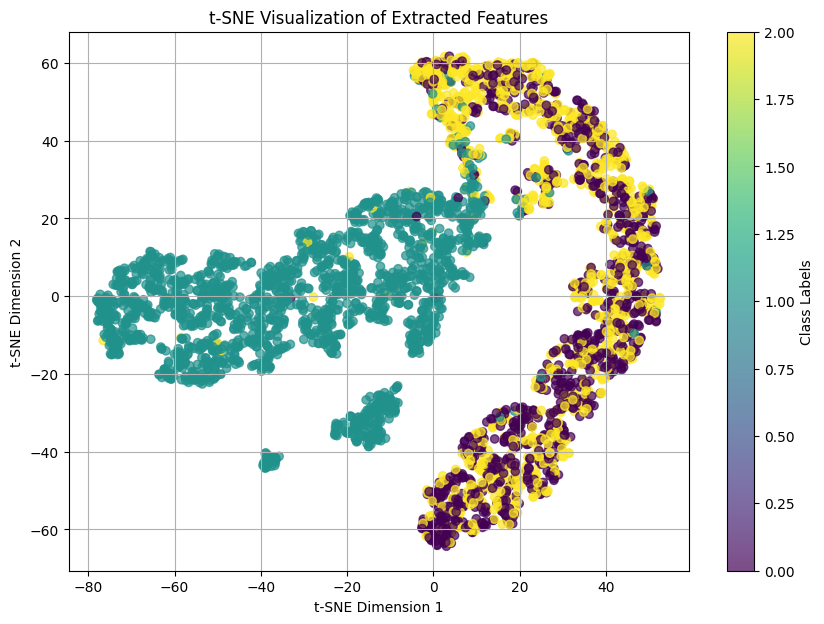

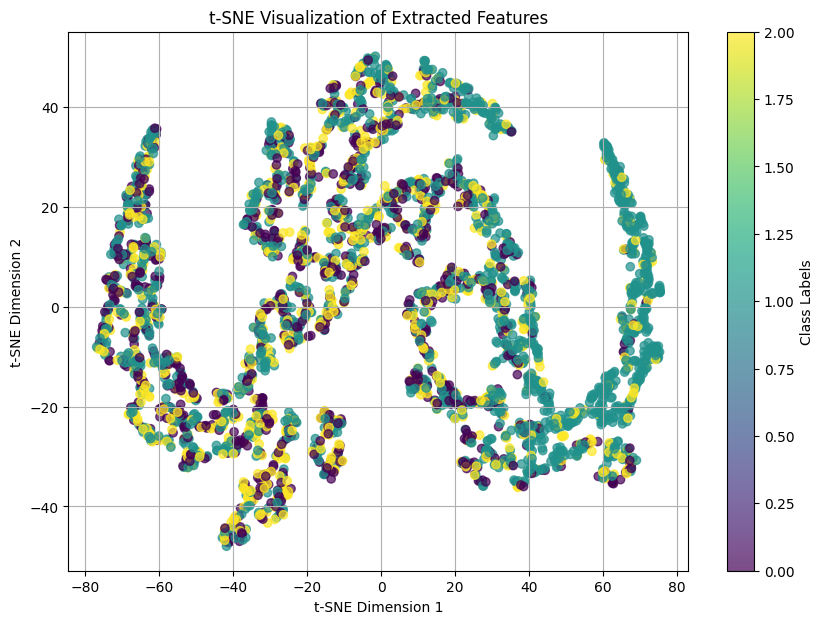

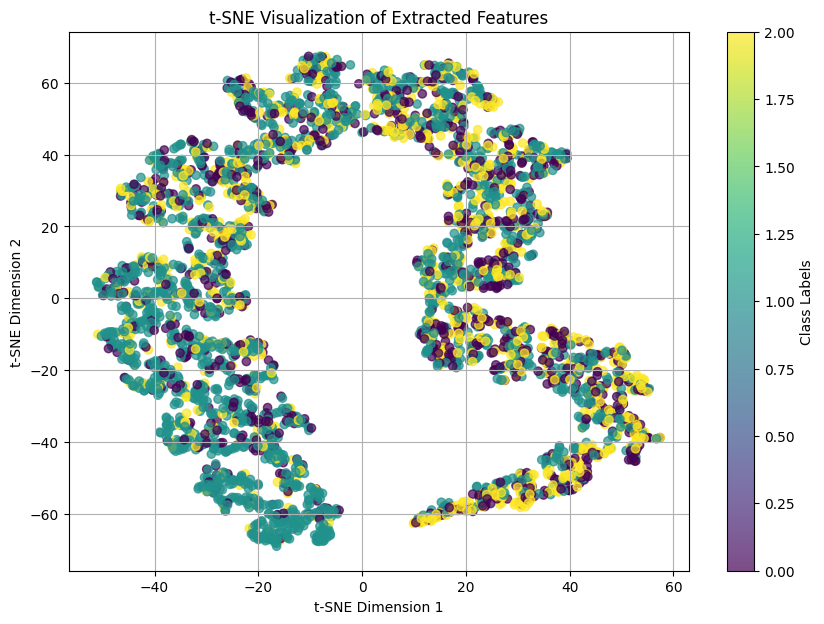

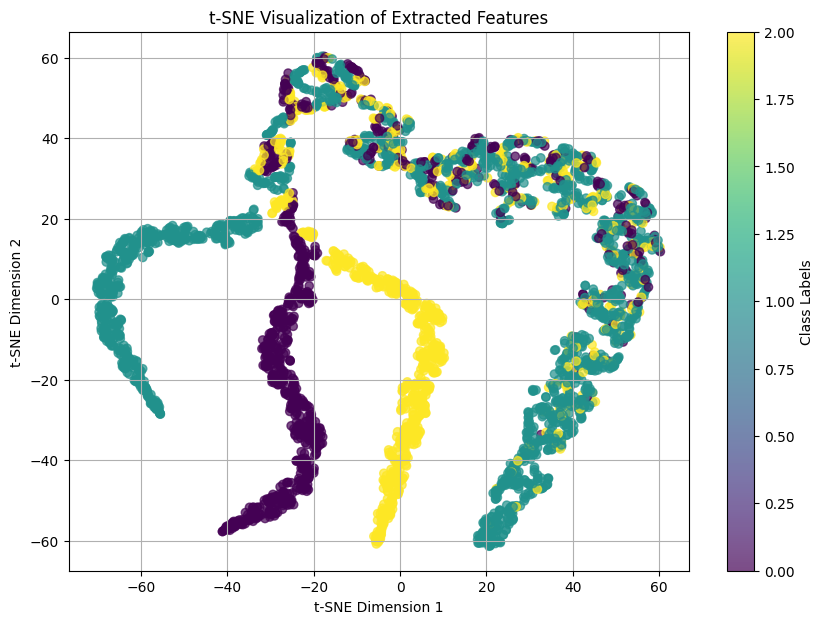

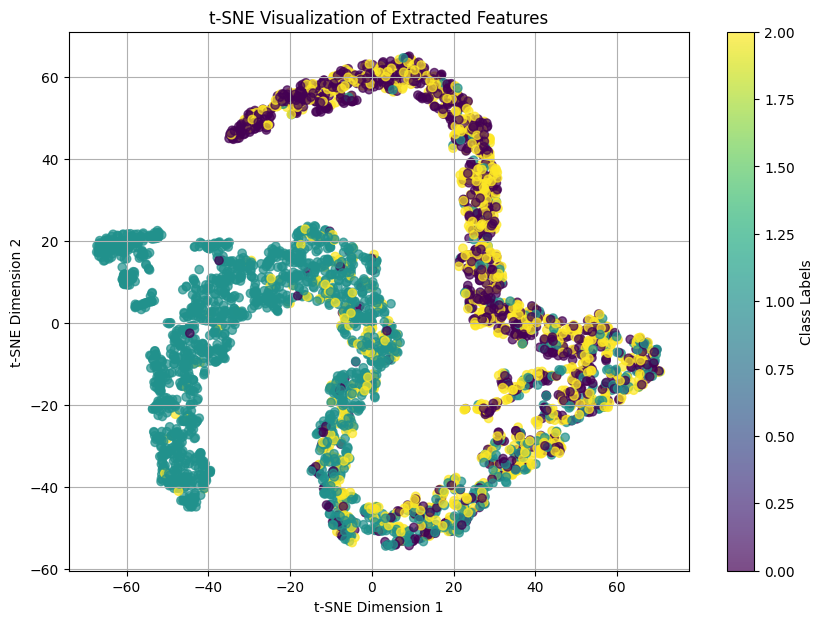

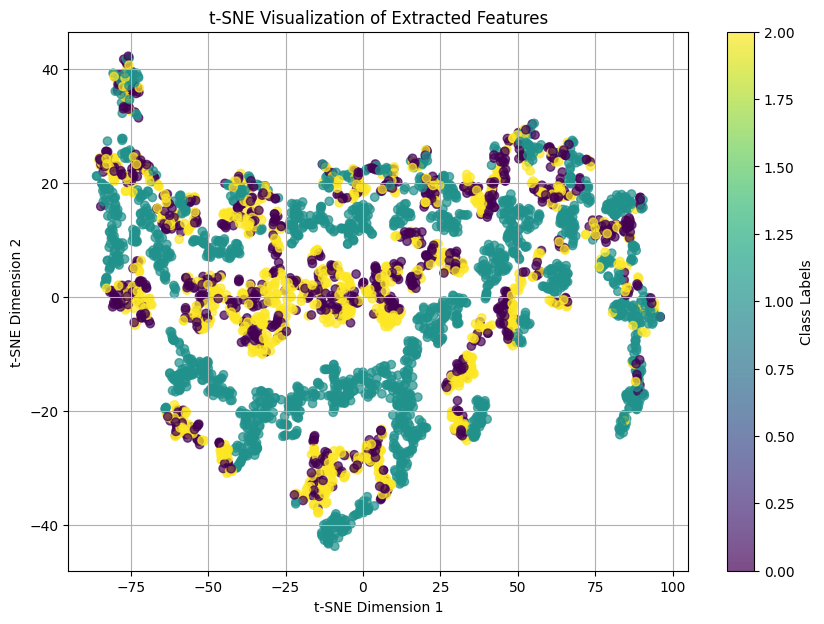

In [7]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from datasets import load_dataset
from transformers import AutoModelForCausalLM, GitProcessor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================
# Constants and Configuration
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABEL_MAPPING = {"cooperation": 0, "single": 1, "competition": 2}
DATA_FILES_DIR = "image_gt_train.json"
ROOT_LIST = [
    "bgOn_heatmapOn_trajOn",
    "bgOn_heatmapOn_trajOff",
    "bgOn_heatmapOff_trajOn",
    "bgOff_heatmapOn_trajOn",
    "bgOff_heatmapOn_trajOff",
    "bgOff_heatmapOff_trajOn"
]

# ============================================================
# Functions for Feature Extraction and t-SNE Visualization
# ============================================================
def concatenate_images(image1_path, image2_path):
    """Concatenate two images vertically."""
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path).resize((image1.width, image1.height))
    concatenated_image = Image.new("RGB", (image1.width, image1.height * 2))
    concatenated_image.paste(image1, (0, 0))
    concatenated_image.paste(image2, (0, image1.height))
    return concatenated_image

def extract_features(model, processor, test_ds):
    """Extract features from the Git model for t-SNE."""
    all_features, all_labels = [], []
    for idx in tqdm(range(len(test_ds)), desc="Extracting Features"):
        img1_path = os.path.join(ROOT_DIR, test_ds[idx]["image1"])
        img2_path = os.path.join(ROOT_DIR, test_ds[idx]["image2"])
        concatenated_image = concatenate_images(img1_path, img2_path)

        # Preprocess and extract features
        inputs = processor(images=concatenated_image, text=test_ds[idx]["class"], return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            # Forward pass through the model
            outputs = model(**inputs)  # Model forward pass
            #features = outputs.last_hidden_state
            features = outputs.logits.mean(dim=1).squeeze().cpu().numpy()  # Aggregate logits
        
        all_features.append(features)
        all_labels.append(LABEL_MAPPING[test_ds[idx]["class"].lower()])
    
    return np.array(all_features), np.array(all_labels)


def plot_tsne(features, labels):
    """Plot t-SNE visualization."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Class Labels')
    plt.title('t-SNE Visualization of Extracted Features (Git Model)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.savefig("tsne_visualization_git.png", dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# Main Script
# ============================================================
if __name__ == "__main__":
    for root_dir in ROOT_LIST:
        # Load model and processor
        CHECKPOINT_PATH = os.path.join(root_dir, "git_checkpoint", "checkpoint-590")
        print(f"Loading checkpoint from: {CHECKPOINT_PATH}")
        processor = GitProcessor.from_pretrained("microsoft/git-base")
        model = AutoModelForCausalLM.from_pretrained(CHECKPOINT_PATH).to(DEVICE)

        # Load dataset
        test_ds = load_dataset("json", data_files=DATA_FILES_DIR, split="train")
        
        # Extract features and plot t-SNE
        features, labels = extract_features(model, processor, test_ds)

        # t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(features)

        # Plotting t-SNE results
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Class Labels')
        plt.title('t-SNE Visualization of Extracted Features')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid(True)
        
        fig_file = os.path.join(root_dir, "git_checkpoint/tsne.png")
        plt.savefig(fig_file, dpi=300, bbox_inches='tight')


## 2. ResNet50 Result

In [7]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================
# Constants and Configuration
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LABEL_MAPPING = {"cooperation": 0, "single": 1, "competition": 2}
DATA_FILES_DIR = "image_gt_train.json"  # Directory containing test dataset

ROOT_LIST = [
    "bgOn_heatmapOn_trajOn",
    "bgOn_heatmapOn_trajOff",
    "bgOn_heatmapOff_trajOn",
    "bgOff_heatmapOn_trajOn",
    "bgOff_heatmapOn_trajOff",
    "bgOff_heatmapOff_trajOn"
]

# ============================================================
# Functions for Feature Extraction and t-SNE Visualization
# ============================================================
def extract_features(model, processor, test_ds):
    """Extract features from the test dataset."""
    all_features, all_labels = [], []
    for idx in tqdm(range(len(test_ds)), desc="Extracting Features"):
        # Prepare concatenated image
        img1_path = os.path.join(ROOT_DIR, test_ds[idx]["image1"])
        img2_path = os.path.join(ROOT_DIR, test_ds[idx]["image2"])
        concatenated_image = concatenate_images(img1_path, img2_path)

        # Preprocess and extract features
        inputs = processor(images=concatenated_image, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = model(inputs["pixel_values"])
            features = outputs.logits.squeeze().cpu().numpy()
        
        all_features.append(features)
        all_labels.append(LABEL_MAPPING[test_ds[idx]["class"].lower()])
    
    return np.array(all_features), np.array(all_labels)

def concatenate_images(image1_path, image2_path):
    """Concatenate two images vertically."""
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path).resize((image1.width, image1.height))
    concatenated_image = Image.new("RGB", (image1.width, image1.height * 2))
    concatenated_image.paste(image1, (0, 0))
    concatenated_image.paste(image2, (0, image1.height))
    return concatenated_image

def plot_tsne(features, labels):
    """Plot t-SNE visualization."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Class Labels')
    plt.title('t-SNE Visualization of Extracted Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    #plt.savefig("tsne_visualization.png", dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# Main Script
# ============================================================
if __name__ == "__main__":
    for root_dir in ROOT_LIST:
        # Load model and processor
        CHECKPOINT_PATH = os.path.join(root_dir, "res_checkpoint", "checkpoint-590")
        print(f"Loading checkpoint from: {CHECKPOINT_PATH}")
        processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
        model = ResNetForImageClassification.from_pretrained(
            CHECKPOINT_PATH,
            num_labels=3,
            ignore_mismatched_sizes=True
        ).to(DEVICE)

        # Load dataset
        #test_file = os.path.join(DATA_FILES_DIR, "example_test.json")  # Replace with your test dataset
        test_ds = load_dataset("json", data_files=DATA_FILES_DIR, split="train")
        
        # Extract features and plot t-SNE
        features, labels = extract_features(model, processor, test_ds)

        # t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(features)

        # Plotting t-SNE results
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Class Labels')
        plt.title('t-SNE Visualization of Extracted Features')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid(True)
        
        fig_file = os.path.join(root_dir, "res_checkpoint/tsne.png")
        plt.savefig(fig_file, dpi=300, bbox_inches='tight')



========== Inference and Evaluation for ROOT: bgOn_heatmapOn_trajOn ==========
               mean       std
Accuracy   0.578233  0.033807
Precision  0.610813  0.125913
Recall     0.578233  0.033807
F1-Score   0.475607  0.044998

========== Inference and Evaluation for ROOT: bgOn_heatmapOn_trajOff ==========
               mean       std
Accuracy   0.566739  0.033673
Precision  0.484527  0.082385
Recall     0.566739  0.033673
F1-Score   0.455419  0.041438

========== Inference and Evaluation for ROOT: bgOn_heatmapOff_trajOn ==========
               mean       std
Accuracy   0.498420  0.030480
Precision  0.389208  0.150623
Recall     0.498420  0.030480
F1-Score   0.337217  0.030841

========== Inference and Evaluation for ROOT: bgOff_heatmapOn_trajOn ==========
               mean       std
Accuracy   0.563793  0.030908
Precision  0.616104  0.088665
Recall     0.563793  0.030908
F1-Score   0.459296  0.043161

========== Inference and Evaluation for ROOT: bgOff_heatmapOn_trajOff ======

## 3. SVM Result

In [9]:
import os
import torch
import json
import numpy as np
import pandas as pd

from PIL import Image
from datasets import load_dataset
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

############################################################
# 1. Configurations
############################################################
ROOT_LIST = [
    "bgOn_heatmapOn_trajOn",
    "bgOn_heatmapOn_trajOff",
    "bgOn_heatmapOff_trajOn",
    "bgOff_heatmapOn_trajOn",
    "bgOff_heatmapOn_trajOff",
    "bgOff_heatmapOff_trajOn"
]

DATASET_FILE = "./image_gt.json"
LABEL_MAPPING = {"Cooperation": 0, "Single": 1, "Competition": 2}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

############################################################
# 2. Preprocessing / Feature Extractor
############################################################
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()
resnet_model.to(DEVICE)
feature_extractor = torch.nn.Sequential(*list(resnet_model.children())[:-1])
feature_extractor.eval()
feature_extractor.to(DEVICE)

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

############################################################
# 3. Utility Function: Concatenate 2 images vertically
############################################################
def concatenate_images_vertically(img1: Image.Image, img2: Image.Image) -> Image.Image:
    img2 = img2.resize((img1.width, img1.height))
    new_width = img1.width
    new_height = img1.height + img2.height
    new_img = Image.new("RGB", (new_width, new_height))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (0, img1.height))
    return new_img

############################################################
# 4. Dataset Class
############################################################
class MyImageDataset(Dataset):
    def __init__(self, examples, root):
        self.examples = examples
        self.root = root

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        record = self.examples[idx]
        path1 = os.path.join(self.root, record["image1"])
        path2 = os.path.join(self.root, record["image2"])
        label_str = record["class"]

        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")

        concatenated_img = concatenate_images_vertically(img1, img2)
        transformed_img = image_transform(concatenated_img)
        label = LABEL_MAPPING[label_str]
        return transformed_img, label

############################################################
# 5. Feature Extraction Function
############################################################
def extract_features_and_labels(dataset_obj):
    dataloader = DataLoader(dataset_obj, batch_size=8, shuffle=False)
    all_features = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = images.to(DEVICE)
            feats = feature_extractor(images).squeeze()
            if len(feats.shape) == 1:
                feats = feats.unsqueeze(0)
            all_features.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

############################################################
# 6. Main Routine
############################################################
if __name__ == "__main__":
    hf_dataset = load_dataset("json", data_files=DATASET_FILE, split="train")
    records = [hf_dataset[i] for i in range(len(hf_dataset))]

    for root_dir in ROOT_LIST:
        results = []
        print(f"============ Processing ROOT: {root_dir} ============")
        dataset = MyImageDataset(records, root_dir)
        X, y = extract_features_and_labels(dataset)

        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(X)

        # Plotting t-SNE results
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Class Labels')
        plt.title('t-SNE Visualization of Extracted Features')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid(True)
        
        fig_file = os.path.join(root_dir, "svm_result/tsne.png")
        plt.savefig(fig_file, dpi=300, bbox_inches='tight')
        #plt.show()


        print(f"Results saved to {fig_file}!!")



========== Inference and Evaluation for ROOT: bgOn_heatmapOn_trajOn ==========
               mean       std
Accuracy   0.637174  0.018964
Precision  0.627165  0.017671
Recall     0.637174  0.018964
F1         0.623928  0.021719

========== Inference and Evaluation for ROOT: bgOn_heatmapOn_trajOff ==========
               mean       std
Accuracy   0.645870  0.030183
Precision  0.636300  0.032362
Recall     0.645870  0.030183
F1         0.634961  0.030770

========== Inference and Evaluation for ROOT: bgOn_heatmapOff_trajOn ==========
               mean       std
Accuracy   0.589783  0.025082
Precision  0.569218  0.028095
Recall     0.589783  0.025082
F1         0.562284  0.031567

========== Inference and Evaluation for ROOT: bgOff_heatmapOn_trajOn ==========
               mean       std
Accuracy   0.656087  0.011123
Precision  0.647666  0.009734
Recall     0.656087  0.011123
F1         0.642922  0.012511

========== Inference and Evaluation for ROOT: bgOff_heatmapOn_trajOff ======